# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from minisom import MiniSom as SOM
import matplotlib.pyplot as plt

from utils import load_data, pca_componentwise, plot_all_experiments, test_train_split, normalize_files

print("Libraries imported.")

Libraries imported.


# Constants

In [2]:
DATA_DIRECTORY = r"C:\Users\Daniel\Documents\Studium\7. Semester (WS 2020.21)\Seminar Data Mining in der Produktion\Gruppenarbeit\Data"
NORMALIZATION_NORM = "l2"
TEST_TRAIN_SPLIT = 0.1
RANDOM_SEED = 1     # for reproducibility

EXPERIMENT_NAMES = ['C11', 'C13', 'C14', 'C15', 'C16', 'C7', 'C8', 'C9']

# Components
COMPONENTS = [
    ['A_1', 'A_2', 'A_3', 'A_4', 'A_5'],
    ['B_1', 'B_2', 'B_3', 'B_4', 'B_5'],
    ['C_1', 'C_2', 'C_3', 'C_4', 'C_5'],
    ['L_1', 'L_2'],
    ['L_3', 'L_6'],
    ['L_4', 'L_5'],
    ['L_7', 'L_8'],
    ['L_9', 'L_10']
]

L_cols = ['L_1', 'L_2', 'L_3', 'L_4', 'L_5', 'L_6', 'L_7', 'L_8', 'L_9', 'L_10']
A_cols = ['A_1', 'A_2', 'A_3', 'A_4', 'A_5']
B_cols = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5']
C_cols = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5']
column_groups = [L_cols, A_cols, B_cols, C_cols]

print("Constants set.")

Constants set.


# Load and preprocess data

In [30]:
files = load_data(directory=DATA_DIRECTORY)

files = normalize_files(files, normalization_norm=NORMALIZATION_NORM)

#cols_to_include = ["L_2", "L_6", "L_8", "L_10", "L_3", "A_4", "B_5", "C_4"]    Eyeballing from correlation_analysis.py
#cols_to_include = ["L_2", "L_6", "L_7", "L_8", "L_10", "A_4", "A_5", "B_3", "B_4", "B_5", "C_4", "C_5"]  # regression: threshold 0.75
#cols_to_include = ["L_2", "L_6", "L_7", "L_8", "L_10", "A_4", "A_5", "B_4", "B_5", "C_4", "C_5"]  # regression: threshold 0.70
cols_to_include = ["L_2", "L_6", "L_8", "L_10", "A_5", "B_4", "B_5", "C_5"]  # regression: threshold 0.6
files = [file[cols_to_include] for file in files]
# files = pca_componentwise(files, components=COMPONENTS)

train_files, test_files = test_train_split(files, split=TEST_TRAIN_SPLIT)

#cols_to_drop = ["C_5", "B_5", "A_5", 'L_3', 'L_4', 'L_6', 'L_7', 'L_8', 'L_9', 'L_10']
#s = s.drop(cols_to_drop, axis=1)

#s.sum(axis=1).plot()
#c = s[cols_to_include].corr().abs()

TRAINING_DATA = pd.concat(train_files)

print("Loaded and preprocessed data.")

Loaded and preprocessed data.


# Abweichung von Median

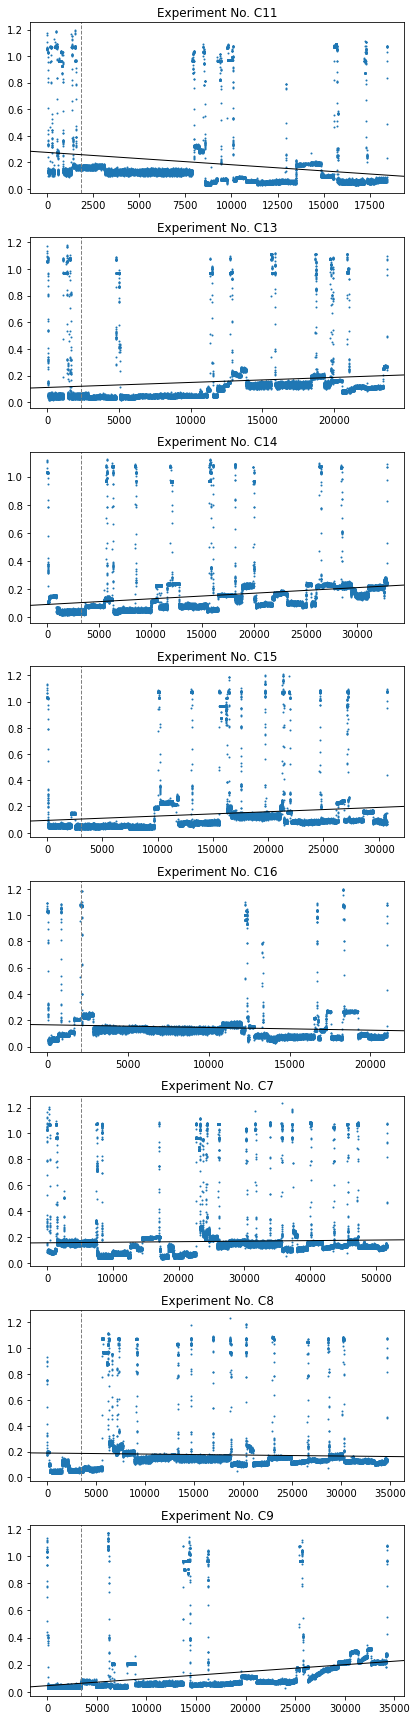

In [34]:
def distance(x: pd.Series, array: pd.DataFrame, norm="l2"):
    """Row-wise distance of array from point x."""
    if norm in ["l2", "euclidean"]:
        order = 2
    elif norm in ["l1", "manhattan"]:
        order = 1
    else:
        order = norm

    return pd.DataFrame(np.linalg.norm(array - x, ord=order, axis=1))

#medians = [pd.DataFrame(train).median() for train in train_files]
median = TRAINING_DATA.median()

#anomalies = [distance(median, file, norm="l2") for file, median in zip(files, medians)]
anomalies = [distance(median, file, norm="l2") for file in files]

plot_all_experiments(anomalies, EXPERIMENT_NAMES, test_train_split=TEST_TRAIN_SPLIT, ols_line=True,
                     savefig=True)

# Abweichung vom Vorherigen

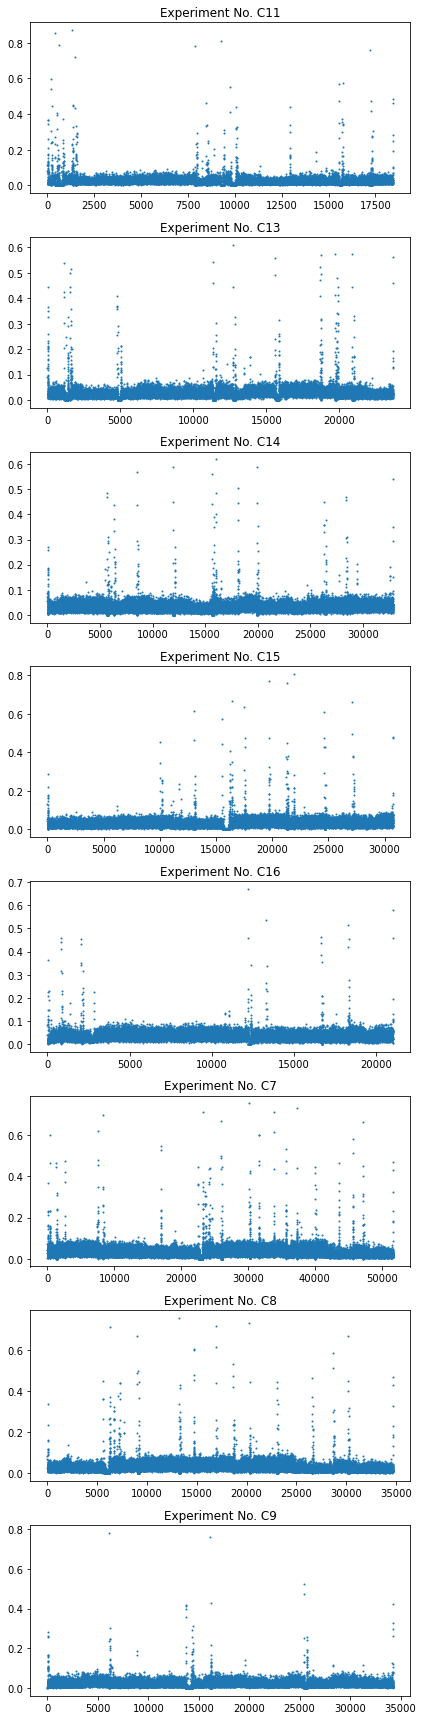

In [6]:
predecessors = [pd.DataFrame(file).shift(1) for file in files]
originals = [pd.DataFrame(file) for file in files]

distances = [pd.DataFrame(np.linalg.norm(orig - pred, ord=2, axis=1)) for orig, pred in zip(originals, predecessors)]

experiment_names = ['C11', 'C13', 'C14', 'C15', 'C16', 'C7', 'C8', 'C9']

plot_all_experiments(distances, experiment_names, test_train_split=None)

# Isolation Forest
Predictions: -1 -> outlier, 1 -> inlier

Wall time: 1.09 s


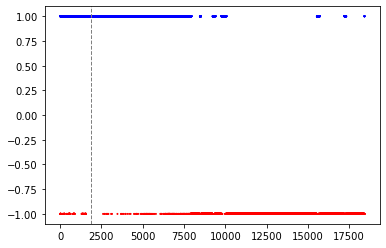

In [8]:
%%time
train, all_data = train_files[0], files[0]

model = IsolationForest(random_state=RANDOM_SEED)
model.fit(train)
predictions = pd.DataFrame(model.predict(all_data))

# Plot
test_train_split_index = int(len(all_data) * TEST_TRAIN_SPLIT)

predictions["color"] = predictions[0].apply(lambda x: "blue" if x == 1.0 else "red")
plt.scatter(x=predictions.index, y=predictions[0], c=predictions["color"], s=1)
plt.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)

# Elliptic Envelope

Wall time: 1.37 s


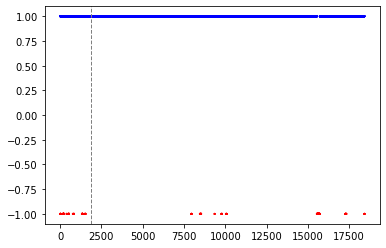

In [10]:
%%time
train, all_data = train_files[0], files[0]

model = EllipticEnvelope(random_state=RANDOM_SEED)
model.fit(train)
predictions = pd.DataFrame(model.predict(all_data))

# Plot
test_train_split_index = int(len(all_data) * TEST_TRAIN_SPLIT)

predictions["color"] = predictions[0].apply(lambda x: "blue" if x == 1.0 else "red")
plt.scatter(x=predictions.index, y=predictions[0], c=predictions["color"], s=1)
plt.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)

# SOM

In [39]:
SOM_MAP_X_DIMENSION = 50      # 50 as taken from research paper
SOM_MAP_Y_DIMENSION = 50     # 50 as taken from research paper
SOM_TRAINING_EPOCHS = 10000

def train_model(training_data):
    model = SOM(x=SOM_MAP_X_DIMENSION, y=SOM_MAP_Y_DIMENSION, input_len=training_data.shape[1], random_seed=RANDOM_SEED)
    model.train(training_data, num_iteration=SOM_TRAINING_EPOCHS, verbose=True)
    return model

models = [train_model(train.to_numpy()) for train in train_files]
#model = train_model(TRAINING_DATA.to_numpy())

print("SOM models trained.")

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.010592387430171983
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.007367413285615913
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.007596909803037032
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.006207569089316568
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.009228169358806656
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.011822561138764573
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.00711537412835174
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.004262099389454687
SOM models trained.


### SOM: Activation on training data (above) and test data (below)

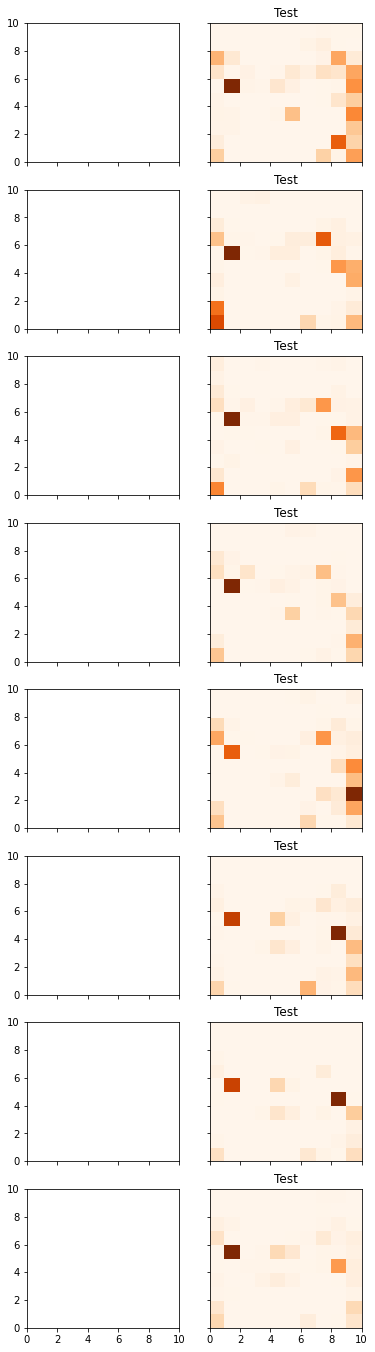

In [35]:
%matplotlib inline

fig, ax = plt.subplots(8, 2, sharex=True, sharey=True)
fig.set_size_inches(6, 24)

for i, test_file in enumerate(test_files):
    """
    frequencies = model.activation_response(train_files[i].to_numpy())
    ax[i, 0].pcolor(frequencies.T, cmap='Blues')
    ax[i, 0].set_title("Training")
    #plt.colorbar()
    """

    frequencies = model.activation_response(test_file.to_numpy())
    ax[i, 1].pcolor(frequencies.T, cmap='Oranges')
    ax[i, 1].set_title("Test")
    #plt.colorbar()

plt.show()

### SOM: Plot quantization errors

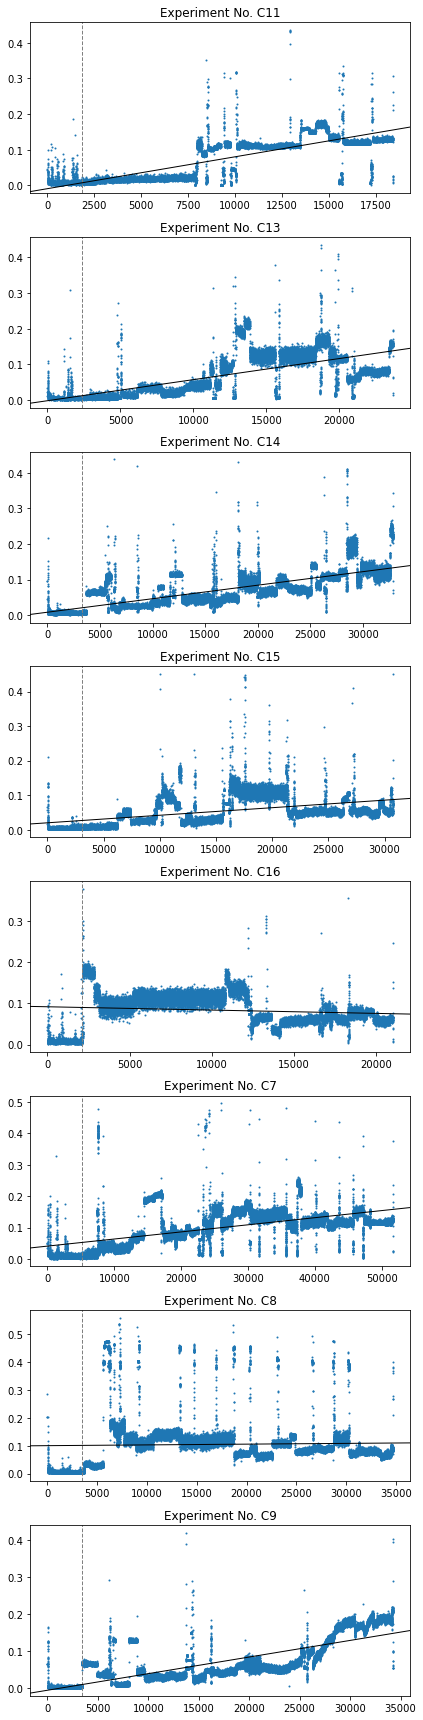

In [40]:
converted_files = [[file[i:i+1].to_numpy() for i in range(len(file) - 1)] for file in files]    # always grab two data points and convert them to numpy (two needed because MiniSom will not evaluate a single one)

quantization_errors = [pd.DataFrame([model.quantization_error(data_point)
                                     for data_point in converted_files[j]])
                       for j, model in enumerate(models)]

""" One model using same training data
quantization_errors = [pd.DataFrame([model.quantization_error(data_point)
                                     for data_point in converted_file])
                       for converted_file in converted_files]
"""

plot_all_experiments(quantization_errors, EXPERIMENT_NAMES, test_train_split=TEST_TRAIN_SPLIT,
                     ols_line=True, savefig=True)


# OneClassSVM Decision Function

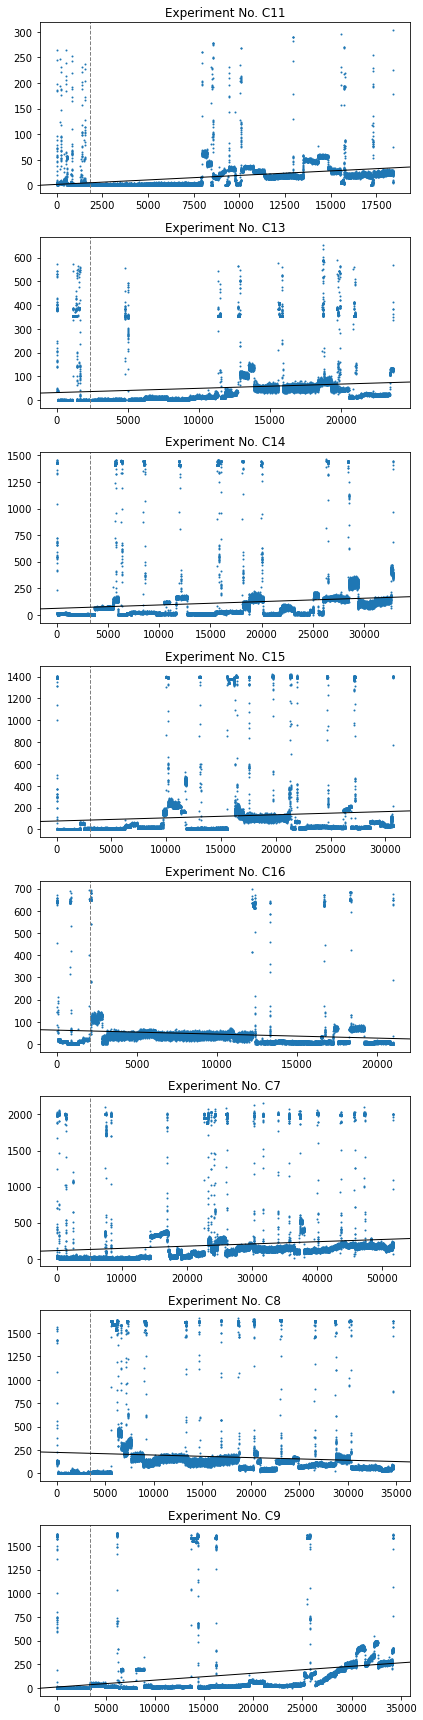

In [43]:
from sklearn.svm import OneClassSVM

svm_models = [OneClassSVM().fit(train) for train in train_files]

distances_to_hyperplane = [pd.DataFrame(svm_models[i].decision_function(file)).abs() for i, file in enumerate(files)]

plot_all_experiments(distances_to_hyperplane, EXPERIMENT_NAMES, test_train_split=TEST_TRAIN_SPLIT,
                     ols_line=True, savefig=True)

# IsolationForest Decision Function

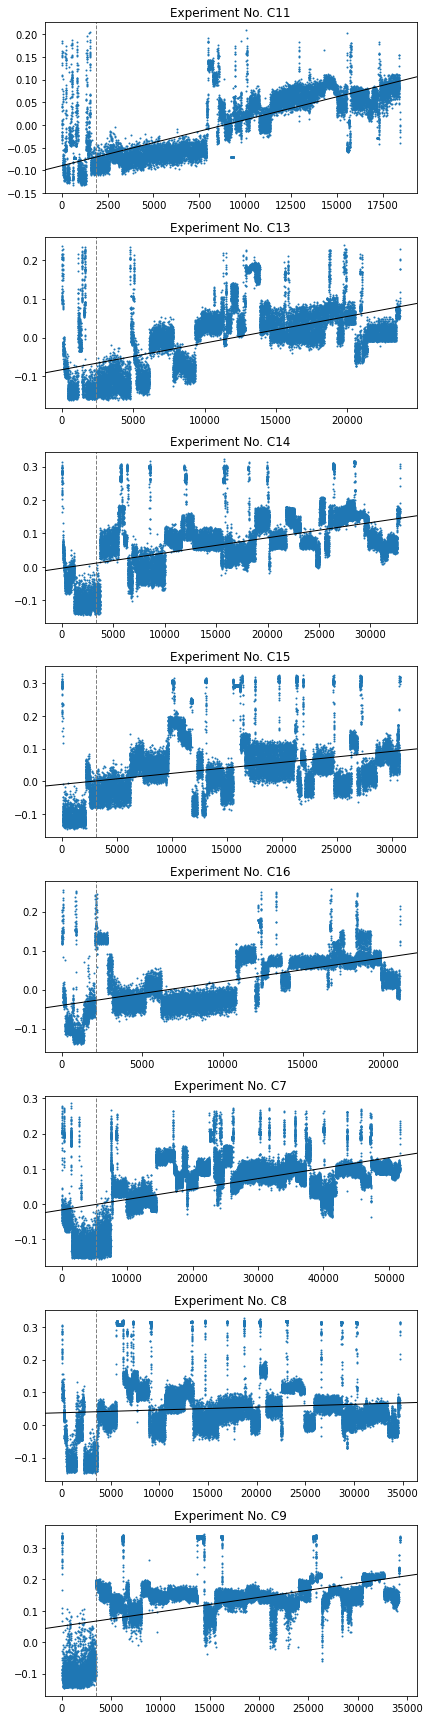

In [45]:
forests = [IsolationForest(random_state=RANDOM_SEED).fit(train) for train in train_files]

avg_anomaly_score = [(pd.DataFrame(forests[i].decision_function(file)) * -1) for i, file in enumerate(files)]

plot_all_experiments(avg_anomaly_score, EXPERIMENT_NAMES, test_train_split=TEST_TRAIN_SPLIT,
                     ols_line=True, savefig=True)

# Feature selection

In [ ]:
c11 = pd.read_csv(DATA_DIRECTORY + "/C11.csv")
c11 = c11.drop("Timestamp", axis=1)

fig, ax = plt.subplots(25)
fig.set_size_inches(6, 50)

for i, col in enumerate(c11.columns):
    ax[i].plot(c11[col])
    ax[i].set_title(col)

plt.tight_layout()

### Use only L_3, L_4, L_5, L_6

##### Isolation Forest

In [ ]:
split_index = int(len(c11) * TEST_TRAIN_SPLIT)
subset = c11[["L_3", "L_4", "L_5", "L_6"]]
train, all_data = subset[:split_index], subset

model = IsolationForest(random_state=RANDOM_SEED)
model.fit(train)
predictions = pd.DataFrame(model.predict(all_data))

# Plot result
predictions["color"] = predictions[0].apply(lambda x: "blue" if x == 1.0 else "red")
plt.scatter(x=predictions.index, y=predictions[0], c=predictions["color"])
plt.axvline(x=split_index, color="grey", linestyle="--", linewidth=1)


##### IsolationForest with all features

In [ ]:
split_index = int(len(c11) * TEST_TRAIN_SPLIT)
train, all_data = c11[:split_index], c11

model = IsolationForest(random_state=RANDOM_SEED)
model.fit(train)
predictions = pd.DataFrame(model.predict(all_data))

# Plot result
predictions["color"] = predictions[0].apply(lambda x: "blue" if x == 1.0 else "red")
plt.scatter(x=predictions.index, y=predictions[0], c=predictions["color"])
plt.axvline(x=split_index, color="grey", linestyle="--", linewidth=1)

# Median method with PCA

In [ ]:
from sklearn.decomposition import PCA
print("imported")

NO_COMPONENTS = 4

In [ ]:
# PCA on each components individually
L_cols = ['L_1', 'L_2', 'L_3', 'L_4', 'L_5', 'L_6', 'L_7', 'L_8', 'L_9', 'L_10']
A_cols = ['A_1', 'A_2', 'A_3', 'A_4', 'A_5']
B_cols = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5']
C_cols = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5']

def pca_individually(df: pd.DataFrame) -> pd.DataFrame:
    subset_A = df[A_cols]
    subset_B = df[B_cols]
    subset_C = df[C_cols]
    subset_L = df[L_cols]

    A_pc_vector = pd.DataFrame(PCA(n_components=1).fit_transform(subset_A))
    B_pc_vector = pd.DataFrame(PCA(n_components=1).fit_transform(subset_B))
    C_pc_vector = pd.DataFrame(PCA(n_components=1).fit_transform(subset_C))
    L_pc_vector = pd.DataFrame(PCA(n_components=1).fit_transform(subset_L))

    return pd.concat([A_pc_vector, B_pc_vector, C_pc_vector, L_pc_vector], axis=1)



In [ ]:
def distance(x, array, norm="l2"):
    """Row-wise distance of array from point x."""
    if norm in ["l2", "euclidean"]:
        order = 2
    elif norm in ["l1", "manhattan"]:
        order = 1
    else:
        order = norm

    return pd.DataFrame(np.linalg.norm(array - x, ord=order, axis=1))

datasets = files

# datasets_after_pca = [pd.DataFrame(PCA(n_components=NO_COMPONENTS).fit_transform(dataset)) for dataset in datasets]
datasets_after_pca = [pca_individually(dataset) for dataset in datasets]
medians = [data[:int(len(data) * TEST_TRAIN_SPLIT)].median() for data in datasets_after_pca]

anomalies = [distance(med, total, norm="l2") for med, total in zip(medians, datasets_after_pca)]

experiment_names = ['C11', 'C13', 'C14', 'C15', 'C16', 'C7', 'C8', 'C9']

plot_all_experiments(anomalies, experiment_names, savefig=True)


In [ ]:
datasets_after_pca[0]

### Median method on subset
With highest deviations: ("L_3", "L_4", "L_5", "L_6")

In [ ]:
subsets = [file[["L_3", "L_4", "L_5", "L_6"]] for file in files]

training_subsets = [subset[:int(len(subset) * TEST_TRAIN_SPLIT)] for subset in subsets]
medians = [train.median() for train in training_subsets]

anomalies = [distance(median, all_data, norm="l2") for median, all_data in zip(medians, subsets)]
experiment_names = ['C11', 'C13', 'C14', 'C15', 'C16', 'C7', 'C8', 'C9']

plot_all_experiments(anomalies, experiment_names, savefig=True)